<a href="https://colab.research.google.com/github/Camilojaravila/202220_MINE-4210_ANALISIS_CON_DEEP_LEARNING/blob/main/Laboratorio%202/Pr%C3%A1ctica%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Laboratorio 2 - Sesión 2**
## **Redes Convolucionales**

## **Objetivos**
*   Realizar la carga y procesamiento de imágenes.
*   Analizar la estructura de una Red Neuronal Convolucional Pre-entrenada.
*   Realizar la transferencia de conocimiento de las Redes Preentrenadas.


## **Problema**
- Uno de los grandes avances que se han propuesto a través de la Visión por Computador es la clasificación de imágenes. Donde a través de ellas se puede establecer directamente a que clase o etiqueta pertenece una imágen sin necesidad de intervención humana. Así que para ello, hemos recuperado un conjunto de imágenes que nos ayudará a entender los conceptos básicos de las Redes Convolucionales a través del [Reconocimiento de Flores](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition). 

## 0. Importación de Librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 3.2 MB/s 
     |████████████████████████████████| 1.6 MB 23.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model

import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


## 1. Perfilamiento y entendimiento de los datos

Primero, descargamos los datos y los extraemos dentro de la máquina, al ser imágenes, el peso y el tiempo de descarga puede ser mucho mayor a lo que veníamos manejando al utilizar la plataforma Kaggle. Pueden seguir [el siguiente tutorial](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) para descargar los datos. así ahorrarnos tiempo de conversiones y procesamientos

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alxmamaev/flowers-recognition
! unzip flowers-recognition.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 96% 216M/225M [00:02<00:00, 109MB/s]
100% 225M/225M [00:02<00:00, 114MB/s]
Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg 

Ahora que vamos a utilizar nuevas librerías como [TensorFlow](https://www.tensorflow.org/) y [Keras](https://keras.io/), podemos realizar la carga de nuestros datos de una manera diferente, para que nuestro modelo le sea más fácil entenderlo y procesarlo, y así ahorrarnos tiempo de conversiones y procesamiento. Para ello utilizaremos el modelo [tf.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

## 2. Preparación de datos

Definimos algunos parámetros, como el tamaño del batch y el tamaño de las imágenes a cargar.

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

utilizaremos la función `image_dataset_from_directory` de TensorFlow, para realizar la carga de nuestras imágenes. Para ello, nos debemos asegurar que nuestra carpeta contenga la siguiente estructura.

```python
main_directory/
    class_a/
        a_image_1.jpg
        a_image_2.jpg
    class_b/
        b_image_1.jpg
        b_image_2.jpg
```

Y con esto garantizado, podemos realizar la división de entrenamiento y test directamente.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/flowers',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/flowers',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


Ya con nuestros Tensores cargados y creados, podemos ver por ejemplo, las clases cargadas.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Y una muestra de las imágenes que se encuentren redimensionadas al tamaño esperado, y se puedan vizualizar correctamente.

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


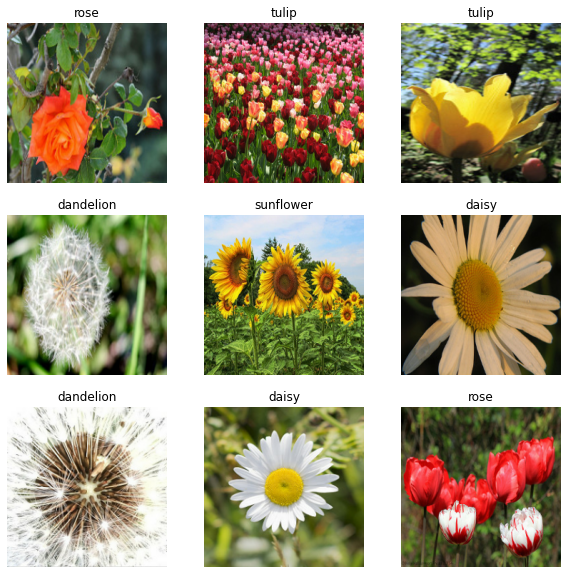

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

## 3. Modelamiento

Utilizaremos una Red preentrenada como lo es la [InceptionV3](https://keras.io/api/applications/inceptionv3/). La cuál está optimizada para mobile y nos ayudará a la tarea de procesamiento de imágenes.

![image](https://miro.medium.com/max/640/1*BCLnBA5cbvnjnUMHGemiTQ.jpeg)

In [ ]:
base_model = InceptionV3(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
clf = Sequential(name='Red_con_Conocimiento')

clf.add(base_model)
clf.add(GlobalAveragePooling2D(name='Pooling'))
clf.add(Dense(50, activation="relu", name='Dense_1'))
clf.add(Dense(10, activation="relu", name='Dense_2'))
clf.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf.summary()

Model: "Red_con_Conocimiento"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 50)                102450    
                                                                 
 Dense_2 (Dense)             (None, 10)                510       
                                                                 
 Dense_out (Dense)           (None, 5)                 55        
                                                                 
Total params: 21,905,799
Trainable params: 21,871,367
Non-trainable params: 34,432
_____________________________

Agregamos un Callback de Parada Temprana.

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]

Ya con nuestro modelo construido y compilado. Ahora sí podemos pasar a entrenarlo.

In [ ]:
with tf.device('/device:GPU:0'): 
    history = clf.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
108/108 [==============================] - 43s 316ms/step - loss: 1.0371 - acc: 0.6390 - precision: 0.8586 - recall: 0.4554 - val_loss: 51.7987 - val_acc: 0.2410 - val_precision: 0.2410 - val_recall: 0.2410
Epoch 2/50
108/108 [==============================] - 31s 282ms/step - loss: 0.6721 - acc: 0.7782 - precision: 0.8709 - recall: 0.6836 - val_loss: 0.9766 - val_acc: 0.6976 - val_precision: 0.7671 - val_recall: 0.5991
Epoch 3/50
108/108 [==============================] - 31s 284ms/step - loss: 0.5573 - acc: 0.8112 - precision: 0.8761 - recall: 0.7554 - val_loss: 0.6667 - val_acc: 0.7625 - val_precision: 0.8452 - val_recall: 0.6895
Epoch 4/50
108/108 [==============================] - 31s 284ms/step - loss: 0.4173 - acc: 0.8686 - precision: 0.9021 - recall: 0.8298 - val_loss: 0.7957 - val_acc: 0.7659 - val_precision: 0.7847 - val_recall: 0.7474
Epoch 5/50
108/108 [==============================] - 31s 282ms/step - loss: 0.3606 - acc: 0.8830 - precision: 0.9149 - recall: 0.8

### 3.1.2. Predicción

Al igual que con nuestros modelos anteriores, podemos realizar las predicciones de nuestro conjunto de datos. Sin embargo, acá hay que realizar una pequeña corrección.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]], dtype=float32), array([[0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0]]))

Y utilizaremos nuestro Reporte de Clasificación para poder interpretar los resultados del modelo.

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.89      0.83      0.86       621
   dandelion       1.00      0.68      0.81       852
        rose       0.83      0.84      0.84       625
   sunflower       0.79      0.97      0.87       585
       tulip       0.78      0.95      0.85       771

   micro avg       0.85      0.85      0.85      3454
   macro avg       0.86      0.85      0.85      3454
weighted avg       0.86      0.85      0.84      3454
 samples avg       0.85      0.85      0.85      3454



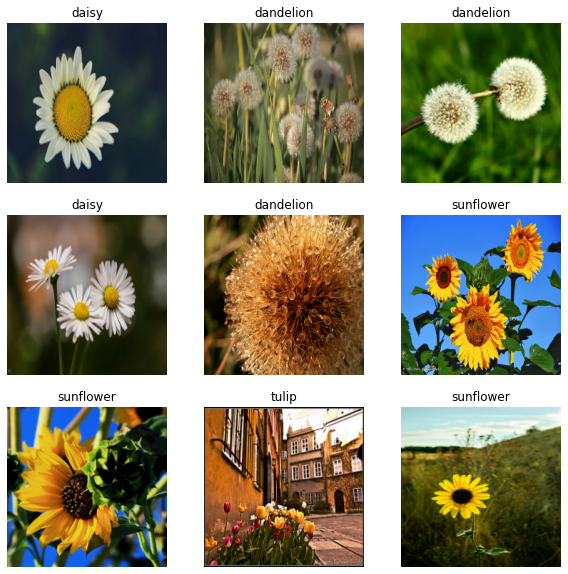

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)

for images, labels in df:
    pred = clf.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Adicionalmente, podemos ver como fue el comportamiento de la pérdida y la exactitud a medida que nuestro modelo fue aprendiendo durante las épocas.

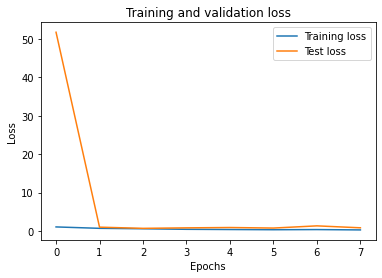

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

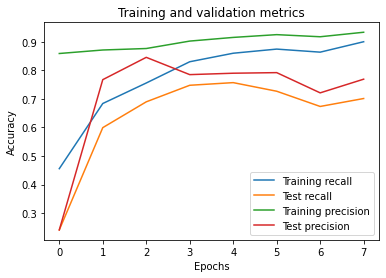

In [ ]:
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Test precision')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. Validación

Y podemos realizar los mismos pasos, pero esta vez con nuestros datos de validación.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = clf.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

(array([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32), array([[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

              precision    recall  f1-score   support

       daisy       0.80      0.73      0.76       143
   dandelion       1.00      0.55      0.71       200
        rose       0.64      0.62      0.63       159
   sunflower       0.75      0.93      0.83       148
       tulip       0.65      0.87      0.74       213

   micro avg       0.74      0.74      0.74       863
   macro avg       0.77      0.74      0.73       863
weighted avg       0.77      0.74      0.73       863
 samples avg       0.74      0.74      0.74       863



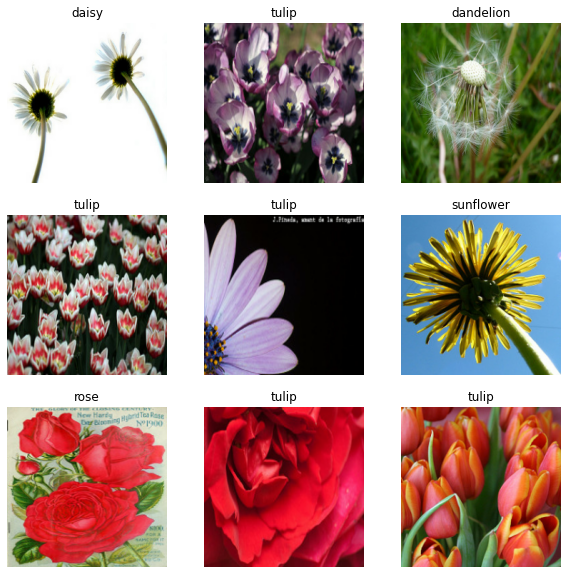

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)

for images, labels in df:
    pred = clf.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

### Preguntas

- ¿Qué hiperparámetros deberíamos entonar en este caso?
- ¿Qué otras Redes Pre-entrenadas podemos utilizar en nuestro modelo?
- ¿Será conveniente realizar diferentes transferencias de conocimiento?